<a href="https://colab.research.google.com/github/zcwisc/GB657/blob/main/Module_3_RunningNNsIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Artificial Neural Nets

In this tutorial, we will get to know artificial neural networks for the purpose of prediction.  Neural nets present a powerful machine learning technique, but there are also various pitfalls.  In the first part of this tutorial, we will demonstrate both their power and key issues.  More precisely, we will look at two separate regression examples where their performance comes out different. This will help us understand some of the accolades and downsides.  

As usually, we start by importing the relevant libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import time

And for later use, we defined the sigmoid function:

In [3]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

## Artificial Neural Networks

### Review of Concepts and Maths

As we discussed in lecture, a neural net generally consists of an *input layer* with the features $X_1,\ldots,X_p,$ one or more *hidden layers* with *neurons* $Z_1,\ldots,Z_M,$ and an *output layer*.  In the case of a one-dimensional regression problem, the output layer consists of a single outcome $Y.$  

In a single-layer neural network, the inputs are processed into the neurons of the hidden layer, which in turn are processed into the outputs.  More precisely, for each neuron $Z_m$, the $X_j$'s are linearly aggregated and transformed via a sigmoid function:   
$$
\boxed{\begin{array}{rcl}
Z_m &=& \sigma(\alpha_{0m} +
\alpha_{m,1}\,X_1 + \alpha_{m,2}\,X_2 + \ldots + \alpha_{m,p}\,X_p)\\
Y &=& \beta_0 + \beta_1\,Z_1 + \beta_2\,Z_2 + \ldots + \beta_M\,Z_M + \varepsilon
\end{array}}
$$
The sigmoid function has the appealing property that it can depict highly linear and highly non-linear relationships.  The constant term ($\alpha_{0m}$) together with the norm of the coefficient vector $(\alpha_{m1},\ldots,\alpha_{mp})$ determines how (non-)linear the relationship in that neuron is.  The neurons are then aggregated to the response $Y.$  In a *deep* neural network, there are several hidden layers in which the neurons are processed into other neurons.

As a consequence, the number of parameters in a neural network quickly becomes large:  For instance, in a single-layer network with a one-dimensional response, we have *weights* for each neuron ($\{\alpha_{0m},\alpha_{m},m=1,\ldots,M\}$), amounting to $M \times (p+1)$ parameters, and then another $M+1$ parameters in producing $Y$ ($\{\beta_0,\beta\}$).  The number increases drastically for more hidden layers.

### Simulated Example I: Complex Relationship, No Noise, Lots of Data

We start with a rather complex relationship between inputs and outputs but assume there is no random noise ($\varepsilon$ is zero) and that we are in a data-rich environment:


In [3]:
np.random.seed(1)
x1 = np.random.normal(0, 1, 30000)
x2 = np.random.normal(0, 1, 30000)
y = (x1+0.5)*(x1+0.5)*(x1+0.5)*(x2-0.3)*(x2-0.3)+50*1/(1+np.exp(3*x1+2*x2))

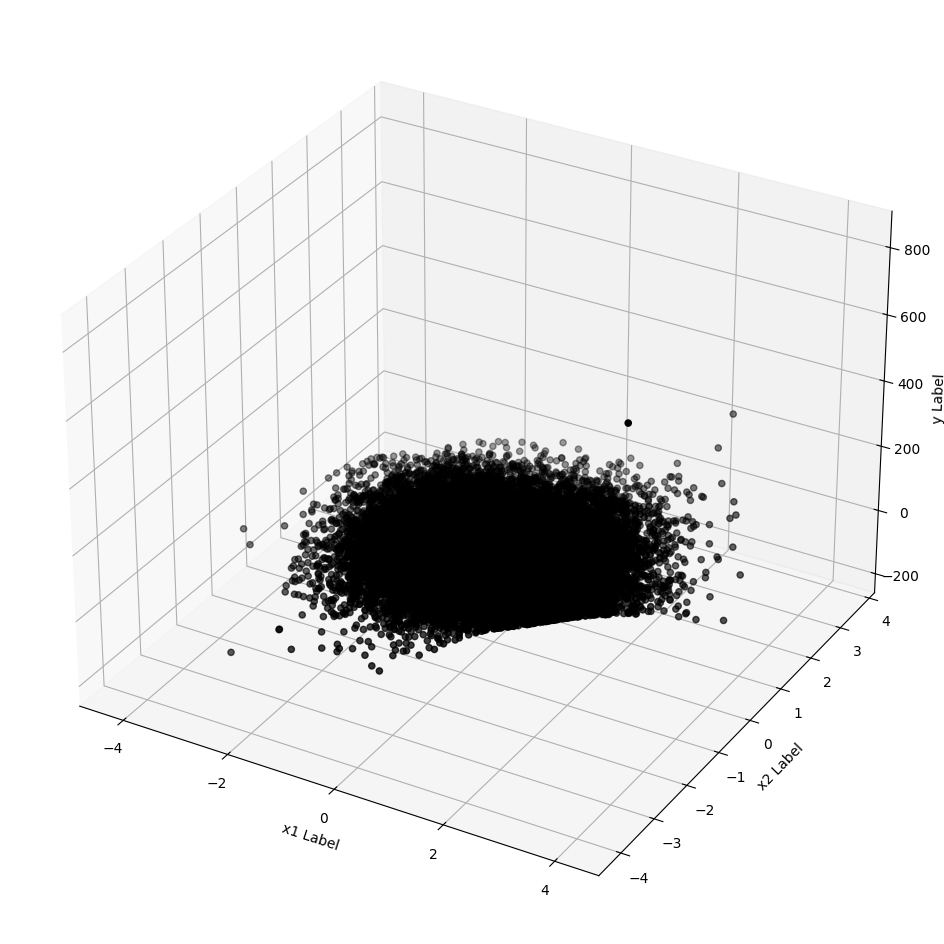

In [4]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y, c='k', marker='o')

ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

So we observe that the relationship is relatively complex in both variables.  


Let's zoom in a bit:

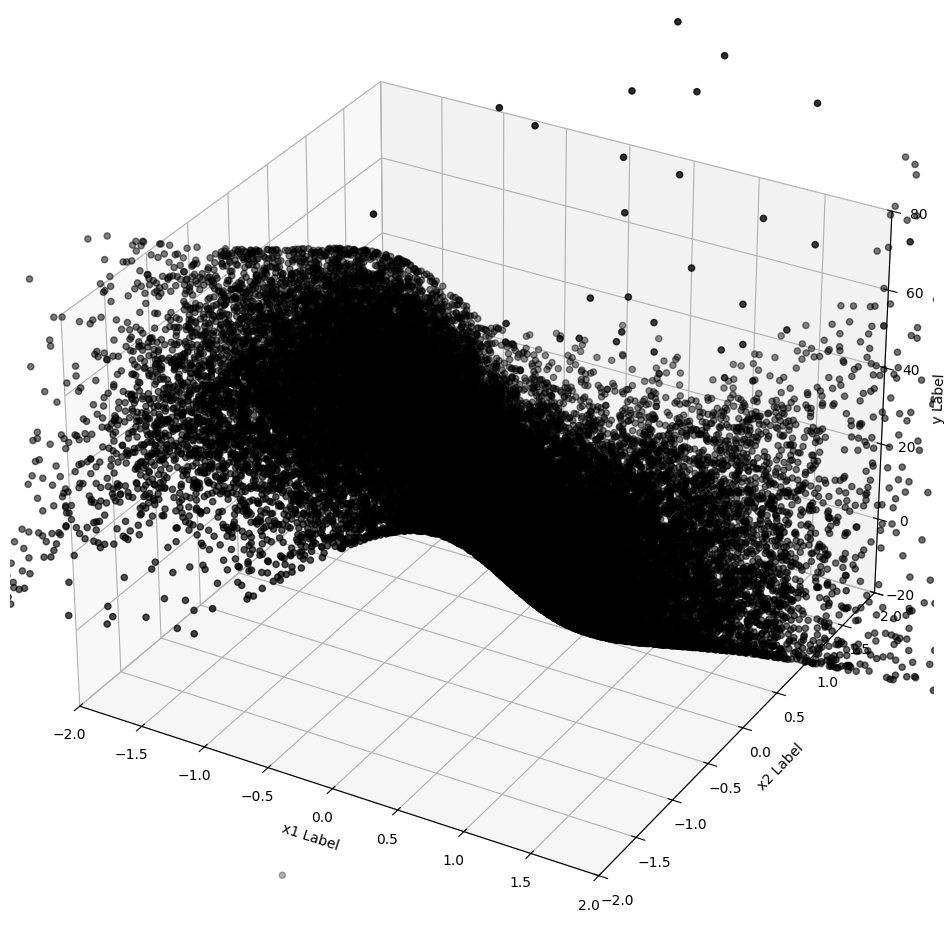

In [5]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,80)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

Let's see if a neural network can fit the relationship.

There are multiple choices for neuralnetwork packages in Python. The one from scikit has similar setting the one in R. Here we rely on keras in tensorflow, which is a package that can do heavy lifting.

We start by putting together the dataframe...

In [6]:
mydata1 = pd.DataFrame({'y':y,'x1':x1,'x2':x2})

...and scale the data:

In [7]:
from sklearn.preprocessing import StandardScaler

# Define the training set size
train_size = 20000

# Separate the training data to calculate scaling parameters
mydata1_train = mydata1.head(train_size)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the entire dataset
mydata1_sc = scaler.fit_transform(mydata1_train) # Fit on training, transform training
mydata1_sc_full = scaler.transform(mydata1) # Transform the full dataset using parameters from training

# Now you can use mydata1_sc for your training data and mydata1_sc_full for the full dataset
# If you need the scaled features and target for the entire dataset:
X_full_sc = mydata1_sc_full[:, 1:3]
y_full_sc = mydata1_sc_full[:, 0]



In [8]:
train_size = 20000
test_size = 10000

# Split the scaled data
X_train = X_full_sc[:train_size]
y_train = y_full_sc[:train_size]

X_test = X_full_sc[train_size:train_size + test_size]
y_test = y_full_sc[train_size:train_size + test_size]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (20000, 2)
Shape of y_train: (20000,)
Shape of X_test: (10000, 2)
Shape of y_test: (10000,)


Let's run a simple network with two layers and three neurons in the first layer and 3 neurons in the second layer:

We can use tensorflow keras:

In [9]:
# Check for GPU and move model to GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = "/GPU:0"
    print("GPU is available, using GPU.")
else:
    device_name = "/CPU:0"
    print("GPU not available, using CPU.")


# define the neural network
with tf.device(device_name):
    inputs = keras.Input(shape=(2,))  # two-dimensional input
    x = layers.Dense(5, activation="sigmoid", name="dense_1")(inputs)
    z = layers.Dense(3, activation="sigmoid", name="dense_2")(x)
    outputs = layers.Dense(1, activation="linear", name="predictions")(z)

    model_keras = keras.Model(inputs=inputs, outputs=outputs)

    model_keras.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()],
    )

# Train and time the process
start_time = time.time()
history = model_keras.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100
)
end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

GPU is available, using GPU.
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8809 - mean_squared_error: 0.8809
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4206 - mean_squared_error: 0.4206
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2518 - mean_squared_error: 0.2518
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2803 - mean_squared_error: 0.2803
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2138 - mean_squared_error: 0.2138
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2299 - mean_squared_error: 0.2299
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1774 - mean_squared_error: 0.1774
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1746 - mean_squared_error: 0.1746
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2830 - mean_squared_error: 0.2830
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1961 - mean_squared_error: 0.1961


Alternatively, we can use PyTorch

In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.dense_1 = nn.Linear(2, 5) # Input layer to first hidden layer (2 inputs, 5 neurons)
        self.sigmoid1 = nn.Sigmoid()
        self.dense_2 = nn.Linear(5, 3) # First hidden layer to second hidden layer (5 neurons, 3 neurons)
        self.sigmoid2 = nn.Sigmoid()
        self.predictions = nn.Linear(3, 1) # Second hidden layer to output layer (3 neurons, 1 output)

    def forward(self, x):
        x = self.sigmoid1(self.dense_1(x))
        x = self.sigmoid2(self.dense_2(x))
        x = self.predictions(x)
        return x

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setup
model_torch = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.01)


# Prepare data
X_train_pt = torch.tensor(X_train, dtype=torch.float32)
y_train_pt = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

train_data = TensorDataset(X_train_pt, y_train_pt)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


# Training loop with timing
epochs = 100
start_time = time.time()

model_torch.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_torch(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)

    # Average loss per sample
    epoch_loss /= len(train_loader.dataset)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

Using device: cuda
Epoch [10/100] - Loss: 0.1274
Epoch [20/100] - Loss: 0.0798
Epoch [30/100] - Loss: 0.0658
Epoch [40/100] - Loss: 0.0576
Epoch [50/100] - Loss: 0.0491
Epoch [60/100] - Loss: 0.0432
Epoch [70/100] - Loss: 0.0377
Epoch [80/100] - Loss: 0.0358
Epoch [90/100] - Loss: 0.0307
Epoch [100/100] - Loss: 0.0292
Total training time: 59.21 seconds


Running on CPU takes: 89/76 seconds

Running on GPU takes: 61/59 seconds

Let's look at the predictions:

In [11]:
# 1. Make predictions with Keras model
# TensorFlow automatically uses GPU if available
pred_sc_keras = model_keras.predict(X_test, verbose=0)

# Rescale using training data stats
y_std = np.std(mydata1.head(train_size)['y'])
y_mean = np.mean(mydata1.head(train_size)['y'])
preds_1_keras = pred_sc_keras * y_std + y_mean

# Get the original test y values
y_test_orig = mydata1['y'][train_size:train_size + test_size].reset_index(drop=True)

# Combine into comparison DataFrame
compare_keras = pd.DataFrame({
    'y_test_orig': y_test_orig,
    'preds_1_keras': preds_1_keras.squeeze()
})
display(compare_keras.head())



# 2. Make predictions with PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_torch.to(device)
model_torch.eval()

with torch.no_grad():
    X_test_pt = torch.tensor(X_test, dtype=torch.float32).to(device)
    pred_sc_pt = model_torch(X_test_pt)
    preds_np = pred_sc_pt.squeeze().detach().cpu().numpy()  # move to CPU + numpy

# Rescale using same training stats
preds_1_pt = preds_np * y_std + y_mean

# Combine into comparison DataFrame
compare_pt = pd.DataFrame({
    'y_test_orig': y_test_orig,
    'preds_1_pt': preds_1_pt
})
display(compare_pt.head())

,y_test_orig,preds_1_keras
0,45.792807,46.137263
1,38.665298,37.227726
2,44.573841,43.157368
3,47.969531,47.136746
4,3.988108,7.579773


,y_test_orig,preds_1_pt
0,45.792807,48.848807
1,38.665298,39.180580
2,44.573841,44.464985
3,47.969531,47.518553
4,3.988108,3.571871


In [12]:
# --- Evaluate Keras Model ---
# Make predictions on the test set
y_pred_keras = model_keras.predict(X_test, verbose=0)

mse_keras = mean_squared_error(y_test, y_pred_keras)
r2_keras = r2_score(y_test, y_pred_keras)

print("Keras Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse_keras:.4f}")
print(f"R-squared (R^2): {r2_keras:.4f}")

# --- Evaluate PyTorch Model ---
# Convert test data to PyTorch tensors
model_torch.to(device)
model_torch.eval()

with torch.no_grad():
    X_test_pt = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_torch = model_torch(X_test_pt)
    y_pred_torch = y_pred_torch.squeeze().detach().cpu().numpy()  # move to CPU + NumPy

# Compute metrics using NumPy arrays
mse_torch = mean_squared_error(y_test, y_pred_torch)
r2_torch = r2_score(y_test, y_pred_torch)

print("\nPyTorch Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse_torch:.4f}")
print(f"R-squared (R^2): {r2_torch:.4f}")

Keras Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.0301
R-squared (R^2): 0.9678

PyTorch Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.0220
R-squared (R^2): 0.9764


So we get pretty close

As we can see, based on the first few predictions, the network seems to work quite well. The plot demonstrates that the neural net fit is able to depict the relationship quite adequately.   

### Simulated Example II: Simple Relationship, Lots of Noise, Little Data

Let's continue with a second example, where the relationship is a lot simpler, the dataset is smaller, and where there is significant noise -- so that the *signal-to-noise ratio* is relatively low.

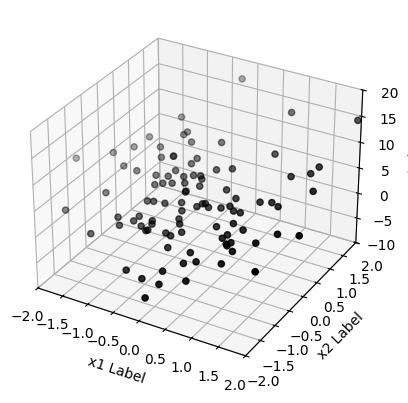

In [4]:
np.random.seed(3)
x1 = np.random.normal(0, 1, 100)
x2 = np.random.normal(0, 1, 100)
x3 = np.random.normal(0, 1, 100)
y2_true = 3 + 2 * x1 + 4 * x2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2_true, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-10,20)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

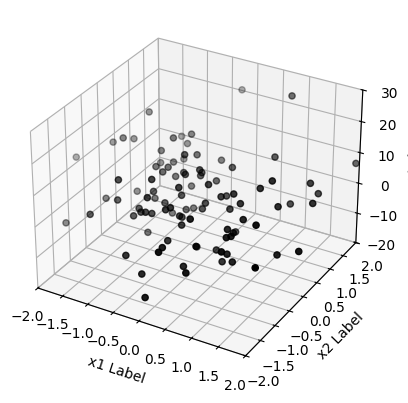

In [5]:
y2 = y2_true + 5 * np.random.normal(0, 1, 100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,30)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

In [6]:
mydata2 = pd.DataFrame({'y2':y2,'x1':x1,'x2':x2,'x3':x3})
mydata2_sc = scale(mydata2)

Let's again run a two-layer neural network:

In [7]:
X_train = mydata2_sc[:,1:4]
y_train = mydata2_sc[:,0]

inputs = keras.Input(shape=(3,))
x = layers.Dense(5, activation="sigmoid", name="dense_1")(inputs)
z = layers.Dense(3, activation="sigmoid", name="dense_2")(x)
outputs = layers.Dense(1, activation="linear", name="predictions")(z)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)

history = model.fit(
    X_train,
    y_train,
    # batch_size=64,
    epochs=50
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 3.6612 - mean_squared_error: 3.6612
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8654 - mean_squared_error: 2.8654
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5975 - mean_squared_error: 2.5975
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.0114 - mean_squared_error: 2.0114 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7506 - mean_squared_error: 1.7506
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6728 - mean_squared_error: 1.6728
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3971 - mean_squared_error: 1.3971 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2275 - mean_squared_error: 1.2275
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1846 - mean_squared_error: 1.1846 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1611 - mean_squared_error: 1.1611
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1672 -

And let's generate predictions:

In [8]:
pred2_sc = model.predict(X_train)
preds_2 = pred2_sc*np.std(mydata2['y2']) + np.mean(mydata2['y2'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [17]:
print(mean_squared_error(y2, preds_2.T[0]))
print(r2_score(y2, preds_2.T[0]))

36.306215109842235
0.09938503262563536


Let's compare to a simple linear regression model:

In [12]:
lmfit = smf.ols(formula="y2 ~ x1 + x2 + x3", data=mydata2).fit()
yhat_OOS = lmfit.predict(mydata2.drop(columns = ["y2"]))
print(lmfit.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     14.33
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           8.68e-08
Time:                        04:35:31   Log-Likelihood:                -308.23
No. Observations:                 100   AIC:                             624.5
Df Residuals:                      96   BIC:                             634.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2953      0.561      4.089      0.0

In [18]:
print(mean_squared_error(y2, yhat_OOS))
print(r2_score(y2, yhat_OOS))

27.846226293624483
0.30924421317238304


As we can see, even though the relationship between the inputs and the (non-noisy) outputs is relatively simple, the neural network predicts a more complex one.  The residuals (relative to the non-noisy outcomes) are quite sizable relative to the data and the predictions.  Clearly, the neural network is overfitting the data.

For the OLS regression, the prediction error is low.  Of course, this may not be suprising given that the original relationship corresponds to a linear model -- but that's the point.  A simpler model will outperform the more advanced model if it is able to accurately depict the relationship!